In [0]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm
import random
from tensorflow.keras.utils import plot_model

In [0]:
colab = True
dataset = 'person_dirty.csv'
use_one_hot = False
epochs = 100
batch_size=32
noise_size=1024

In [0]:
if colab:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)
  data = pd.read_csv('/content/gdrive/My Drive/CS848/Data/' + dataset, low_memory=False)
else:
  data = pd.read_csv('Data/csv/' + dataset)

Mounted at /content/gdrive


In [0]:
def encode_string_col(col):
  encoded = []
  unique_vals = np.unique(col)
  for i,v in enumerate(col):
    ind, = np.where(unique_vals == v)
    encoded.append(ind[0])
  return encoded

In [0]:
for col in data.columns:
  if isinstance(data[col][0], str):
    if use_one_hot:
      one_hot = pd.get_dummies(data[col])
      data = pd.concat([data,one_hot], axis=1)
      data.drop(col, axis=1, inplace=True)
    else:
      data[col] = encode_string_col(data[col].values)
  else:
    dmax = data[col].max()
    dmin = data[col].min()
    data[col] =  ((data[col] - dmin)/(dmax-dmin))
is_dirt = data['is_dirty']
data.drop('is_dirty', axis=1, inplace=True)
data = pd.concat([data, is_dirt], axis=1)

In [0]:
def split_data(data, split=70):
  train_x, train_y, test_x, test_y = [],[],[],[]
  for is_dirty, vals in data.groupby('is_dirty'):
    l = vals.values.tolist()
    ind = int(len(l)*(split/100))
    for t in l[:ind]:
      train_x.append(t[:-1])
      train_y.append(t[-1])
    for t in l[ind:]:
      test_x.append(t[:-1])
      test_y.append(t[-1])
  return list(zip(train_x, train_y)), list(zip(test_x, test_y))

In [0]:
train, test = split_data(data)

In [0]:
def train_test_svm(train, test):
  random.shuffle(train)
  random.shuffle(test)
  X,Y = zip(*train)
  c = svm.SVC()
  c.fit(X, Y)
  conf = np.zeros((2,2), dtype=int)
  for i, t in enumerate(test):
    pred = c.predict([t[0]])
    if pred[0] == 0 and t[1] == 0:
      conf[0][0] +=1
    elif pred[0] == 1 and t[1] == 0:
      conf[0][1] +=1
    elif pred[0] == 0 and t[1] == 1:
      conf[1][0] += 1
    elif pred[0] == 1 and t[1] == 1:
      conf[1][1] += 1
  print(conf)
  return conf

def read_cfm(conf, verbose=True):
  acc = (conf[0][0] + conf[1][1])/np.sum(cf)
  if conf[0][1] == 0 and conf[1][1] == 0:
    prec = 0.000000001
  else:
    prec = conf[1][1]/(conf[1][1] + conf[0][1])
  rec = conf[1][1]/(conf[1][1] + conf[1][0])
  fm = 2*(prec*rec)/(prec+rec)
  if verbose:
    print('Accuracy:', acc)
    print('Precision:', prec)
    print('Recall:',rec )
    print('F-Measure:', fm)
  return [acc, prec, rec, fm]

In [0]:
def wasserstein_loss(pred_y, true_y):
  return keras.backend.mean(pred_y*true_y) 

def generator(inp_size=noise_size, gen_size=8, layer_size=128):
  inp = keras.Input(shape=(noise_size,))
  out_1a = keras.layers.Dense(layer_size)(inp)
  out_1b = keras.layers.BatchNormalization()(out_1a)
  out_1 = keras.layers.Activation('relu')(out_1b)
  out_2a = keras.layers.Dense(layer_size)(out_1) 
  out_2b = keras.layers.BatchNormalization()(out_2a)
  out_2c = keras.layers.Activation('relu')(out_2b)
  out_2 = keras.layers.Concatenate()([out_1, out_2c])
  out_3 = keras.layers.Dense(gen_size, activation='tanh')(out_2)
  gen_model = keras.Model(inputs=inp, outputs=out_3, name='Generator')
  gen_model.compile(loss='binary_crossentropy', optimizer='adam')
  return gen_model

def discriminator(disc_size, layer_size=256):
  disc_model = keras.Sequential(name='Discriminator')
  disc_model.add(keras.layers.Dense(layer_size, input_dim=disc_size))
  disc_model.add(keras.layers.LeakyReLU())
  disc_model.add(keras.layers.Dense(layer_size/2))
  disc_model.add(keras.layers.LeakyReLU())
  # disc_model.add(keras.layers.Dense(layer_size/4))
  # disc_model.add(keras.layers.LeakyReLU())
  disc_model.add(keras.layers.Dense(1))
  disc_model.add(keras.layers.Activation('sigmoid'))

  disc_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return disc_model

def gan_model(gen, disc, inp_size):
  disc.trainable = False
  gan_inp = keras.Input(batch_shape=(None,inp_size))
  g = gen(gan_inp)
  gan_out = disc(g)

  gan = keras.Model(inputs=gan_inp, outputs=gan_out)
  # gan = keras.Sequential()
  # gan.add(gen)
  # gan.add(disc)
  gan.compile(loss='binary_crossentropy', optimizer='adam')
  return gan

In [0]:
x,y = zip(*train)

inds = np.where(np.array(y) == 1)[0]
err_tuples = [x[i] for i in inds]
feature_size = len(err_tuples[0])
print(feature_size)

8


In [0]:
gen_model = generator(noise_size, feature_size)
gen_model.summary()
disc_model = discriminator(feature_size)
disc_model.summary()
gan = gan_model(gen_model, disc_model, noise_size)

gan.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 128)          131200      input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128)          512         dense_6[0][0]                    
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 128)          0           batch_normalization_2[0][0]      
__________________________________________________________________________________________

In [0]:
def get_batch(err_tuples, batch_size=32):
  vals = np.arange(len(err_tuples))
  inds = np.random.choice(vals, size=(batch_size), replace=False)
  return np.array([err_tuples[i] for i in inds]), np.zeros(batch_size)

def get_noise(inp_size, batch_size=32):
  return np.random.normal(size=(batch_size, inp_size))

In [0]:
def train_gan(gan, gen, disc, data, epochs=5000, batch_size=32):
  real_loss = []
  gen_loss = []
  real_acc = []
  gen_acc = []
  for e in range(1, epochs+1):
    if not e % 5:
      print("Epoch " + str(e) + "/" + str(epochs))
    real_data, real_labels = get_batch(data, batch_size)
    noise = get_noise(noise_size, batch_size)
    gen_data = gen.predict(noise)
    gen_labels = np.ones(batch_size)

    disc.trainable = True
    real_out = disc.train_on_batch(real_data, real_labels)
    real_loss.append(real_out[0])
    real_acc.append(real_out[1])
    gen_out = disc.train_on_batch(gen_data, gen_labels)
    gen_loss.append(gen_out[0])
    gen_acc.append(gen_out[1])
    disc.trainable = False
    # noise = get_noise(noise_size, batch_size)
    gan.train_on_batch(noise, gen_labels)
  
  return gan, gen, disc, real_loss, gen_loss, real_acc, gen_acc


Epoch 5/100
Epoch 10/100
Epoch 15/100
Epoch 20/100
Epoch 25/100
Epoch 30/100
Epoch 35/100
Epoch 40/100
Epoch 45/100
Epoch 50/100
Epoch 55/100
Epoch 60/100
Epoch 65/100
Epoch 70/100
Epoch 75/100
Epoch 80/100
Epoch 85/100
Epoch 90/100
Epoch 95/100
Epoch 100/100


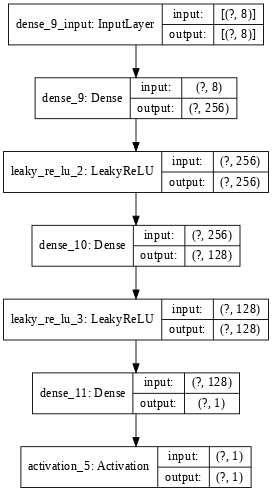

In [0]:
gan, gen, disc, rl, gl, ra, ga = train_gan(gan, gen_model, disc_model, err_tuples, epochs, batch_size)
plot_model(gan, to_file='/content/gdrive/My Drive/CS848/Results/Images/gan.png', show_shapes=True, dpi=64)
plot_model(gen, to_file='/content/gdrive/My Drive/CS848/Results/Images/gen.png', show_shapes=True, dpi=64)
plot_model(disc, to_file='/content/gdrive/My Drive/CS848/Results/Images/disc.png', show_shapes=True, dpi=64)

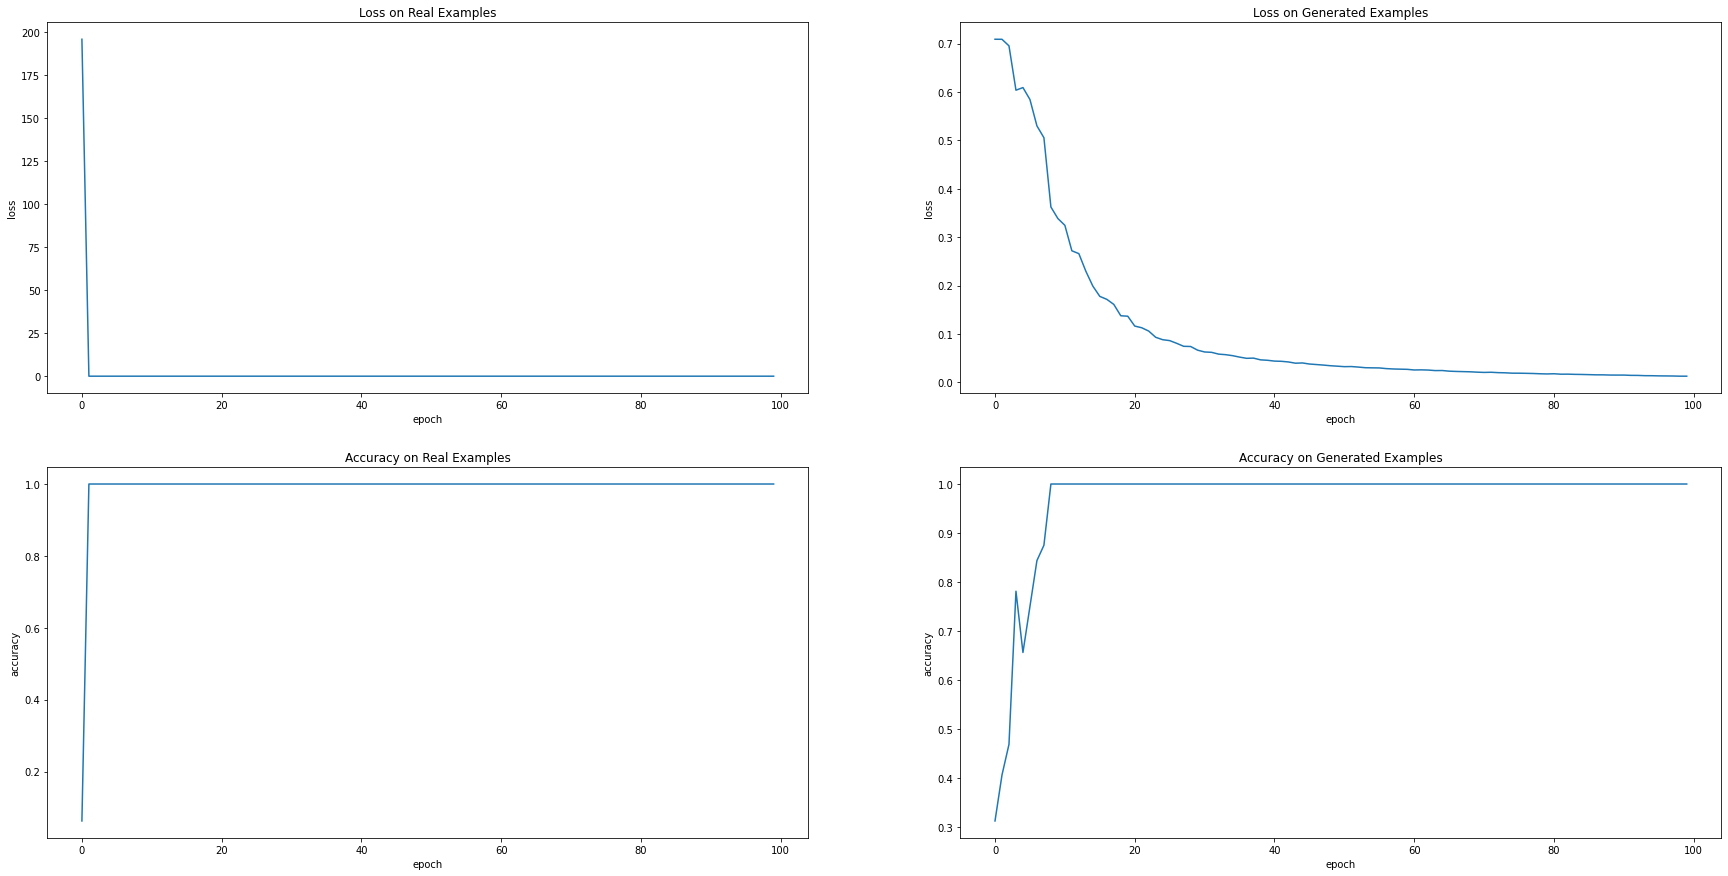

In [0]:
x = np.arange(0,epochs)
f = plt.figure(figsize=(30,15))
ax = f.add_subplot(221)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss on Real Examples')
ax.plot(x, rl)
ax2 = f.add_subplot(222)
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss on Generated Examples')
ax2.plot(x, gl)
ax3 = f.add_subplot(223)
ax3.set_xlabel('epoch')
ax3.set_ylabel('accuracy')
ax3.set_title('Accuracy on Real Examples')
ax3.plot(x, ra)
ax4 = f.add_subplot(224)
ax4.set_xlabel('epoch')
ax4.set_ylabel('accuracy')
ax4.set_title('Accuracy on Generated Examples')
ax4.plot(x, ga)
f.savefig('/content/gdrive/My Drive/CS848/Results/Images/' + dataset + '-loss.png', bbox_inches='tight')

In [0]:
print(gen.predict(get_noise(noise_size, 1)))

[[-0.9993207  -0.9615817  -0.9818932  -0.99762547 -0.999973   -0.9998403
   0.9949876   0.99977887]]


In [0]:
def train_test_svm_gen(train, test, gen, feat_size, gen_percent):
  num_gen = int(len(train)*gen_percent)
  print(num_gen)
  gen_samp = gen.predict(get_noise(noise_size, num_gen))
  random.shuffle(train)
  random.shuffle(test)
  X,Y = zip(*train)
  X = list(X)
  Y = list(Y)
  X.extend( gen_samp)
  print(len(X))
  Y.extend(list(np.ones(num_gen)))
  c = svm.SVC()
  c.fit(X, Y)
  conf = np.zeros((2,2), dtype=int)
  for i, t in enumerate(test):
    pred = c.predict([t[0]])
    if pred[0] == 0 and t[1] == 0:
      conf[0][0] +=1
    elif pred[0] == 1 and t[1] == 0:
      conf[0][1] +=1
    elif pred[0] == 0 and t[1] == 1:
      conf[1][0] += 1
    elif pred[0] == 1 and t[1] == 1:
      conf[1][1] += 1
  print(conf)
  return conf

In [0]:
cms = []
accs = []
precs = []
rcs = []
fms = []
cf = train_test_svm(train, test)
cms.append(cf)
mets = read_cfm(cf)
accs.append(mets[0])
precs.append(mets[1])
rcs.append(mets[2])
fms.append(mets[3])

[[2850    0]
 [ 150    0]]
Accuracy: 0.95
Precision: 1e-09
Recall: 0.0
F-Measure: 0.0


In [0]:
percents = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for p in percents:
  print(p*100, '%')
  conf = train_test_svm_gen(train, test, gen, feature_size, p)
  cms.append(conf)
  mets = read_cfm(conf)
  accs.append(mets[0])
  precs.append(mets[1])
  rcs.append(mets[2])
  fms.append(mets[3])

10.0 %
700
7700
[[2845    5]
 [ 148    2]]
Accuracy: 0.949
Precision: 0.2857142857142857
Recall: 0.013333333333333334
F-Measure: 0.02547770700636943
20.0 %
1400
8400
[[2846    4]
 [ 148    2]]
Accuracy: 0.9493333333333334
Precision: 0.3333333333333333
Recall: 0.013333333333333334
F-Measure: 0.025641025641025644
30.0 %
2100
9100
[[2846    4]
 [ 148    2]]
Accuracy: 0.9493333333333334
Precision: 0.3333333333333333
Recall: 0.013333333333333334
F-Measure: 0.025641025641025644
40.0 %
2800
9800
[[2847    3]
 [ 148    2]]
Accuracy: 0.9496666666666667
Precision: 0.4
Recall: 0.013333333333333334
F-Measure: 0.02580645161290323
50.0 %
3500
10500
[[2847    3]
 [ 148    2]]
Accuracy: 0.9496666666666667
Precision: 0.4
Recall: 0.013333333333333334
F-Measure: 0.02580645161290323
60.0 %
4200
11200
[[2847    3]
 [ 148    2]]
Accuracy: 0.9496666666666667
Precision: 0.4
Recall: 0.013333333333333334
F-Measure: 0.02580645161290323
70.0 %
4900
11900
[[2848    2]
 [ 149    1]]
Accuracy: 0.9496666666666667
Pre

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


13300
[[2848    2]
 [ 150    0]]
Accuracy: 0.9493333333333334
Precision: 0.0
Recall: 0.0
F-Measure: nan
100 %
7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


14000
[[2848    2]
 [ 150    0]]
Accuracy: 0.9493333333333334
Precision: 0.0
Recall: 0.0
F-Measure: nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


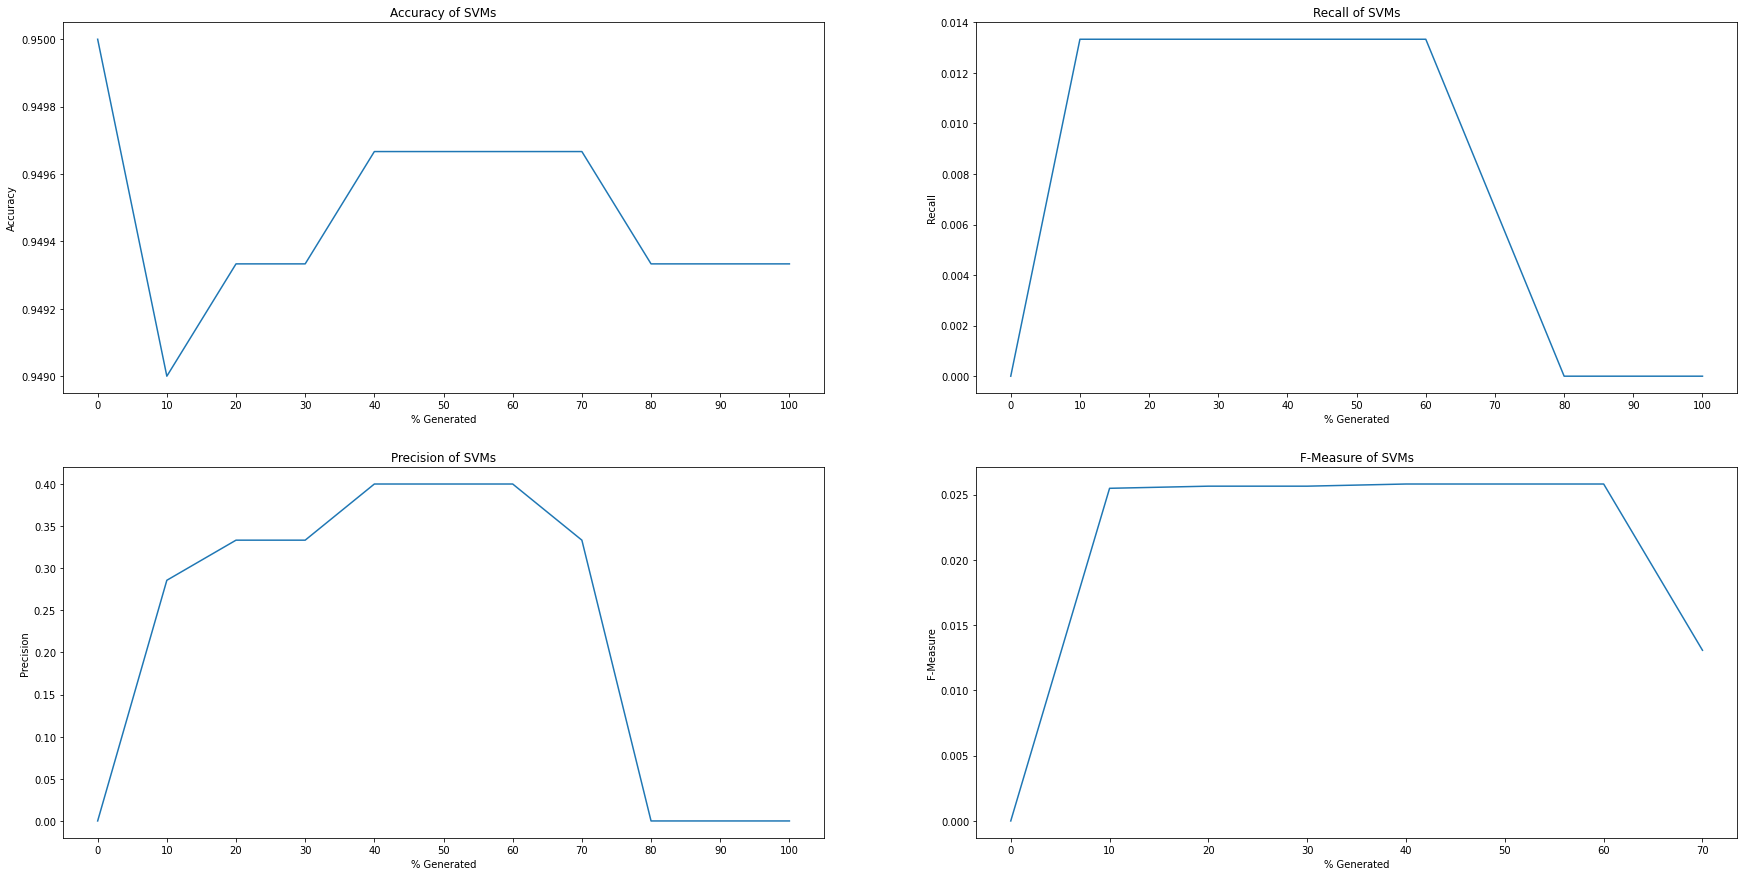

In [0]:
percents = [0] + percents
percents = [int(p*100) for p in percents]
with open('/content/gdrive/My Drive/CS848/Results/Values/'+dataset + '-cms.txt', 'w') as f:
  for i, p in enumerate(percents):
    f.write(str(p) + '\n')
    for c in cms[i]:
      f.write(str(c) + ',')
    f.write('\n')
x = np.arange(0,len(percents))
f = plt.figure(figsize=(30,15))
ax = f.add_subplot(221)
ax.set_xlabel('% Generated')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of SVMs')
ax.set_xticks(np.arange(len(percents)))
ax.set_xticklabels(percents)
ax.plot(x, accs)
ax2 = f.add_subplot(222)
ax2.set_xlabel('% Generated')
ax2.set_ylabel('Recall')
ax2.set_title('Recall of SVMs')
ax2.set_xticks(np.arange(len(percents)))
ax2.set_xticklabels(percents)
ax2.plot(x, rcs)
ax3 = f.add_subplot(223)
ax3.set_xlabel('% Generated')
ax3.set_ylabel('Precision')
ax3.set_title('Precision of SVMs')
ax3.set_xticks(np.arange(len(percents)))
ax3.set_xticklabels(percents)
ax3.plot(x, precs)
ax4 = f.add_subplot(224)
ax4.set_xlabel('% Generated')
ax4.set_ylabel('F-Measure')
ax4.set_title('F-Measure of SVMs')
ax4.set_xticks(np.arange(len(percents)))
ax4.set_xticklabels(percents)
ax4.plot(x, fms)
f.savefig('/content/gdrive/My Drive/CS848/Results/Images/' + dataset + '-svms.png', bbox_inches='tight')